# The Role of Covariance in Analysing Portfolio Risk vs Return
## Correlation and Covariance Matrices
A covariance matrix describes the relationship between different assets returns, with the values along the diagonal being each assets variance. <br>Covariance is defined as follows, where $R_{A}$ is the return of an asset A, $\bar{A}$ is the mean return of asset A over the time period, and N is the number of time periods observed.
### Cov(X,Y) $= \frac{\sum (R_{X}-\bar{X})(R_{Y}-\bar{Y})}{N-1}$
A correlation matrix is the covariance matrix scaled by the reciprocal of the product of each assets standard deviation. Correlation between each asset ranges from -1 to 1, with 1 being the strongest positive correlation, -1 the strongest negative correlation, and 0 being no correlation.
### Corr(X,Y) $= \frac{Cov(X,Y)}{\sigma_{X}\sigma_{Y}}$
In the following example we consider a portfolio consisting of the following symbols: [NVDA, GOOGL, HOOD, UNH, O, NVO]\
Looking at the correlation matrix we see that, apart from the assets with themselves, HOOD and GOOGL have the strongest positive correlation of 0.55 suggesting they tend to move in the same direction. Whilst HOOD and O have the strongest negative correlation of -0.15 suggesting that, although relatively weakly, they tend to move in opposite directions from one another.

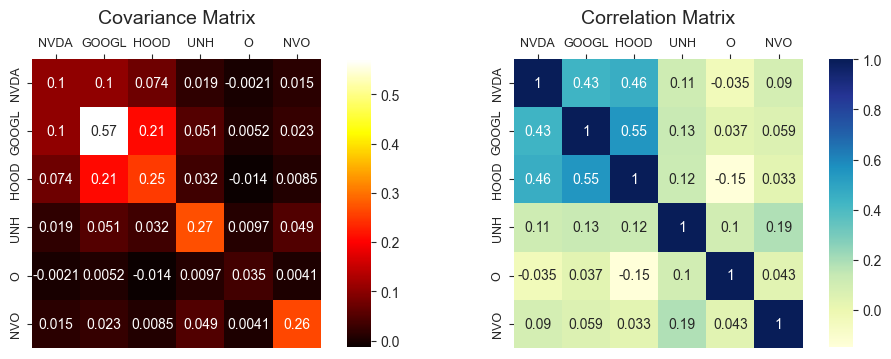

In [1]:
from logReturns import logReturns
import matplotlib.pyplot as plt
from seaborn import heatmap

tickers = "NVDA GOOGL HOOD UNH O NVO"
period = "1y" #one of: [1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max]

logs = logReturns(tickers, period)
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_figheight(11), fig.set_figwidth(11)
heatmap(logs.cov()*252, ax = ax1, annot = True, cmap = "hot", cbar = True, square = True, xticklabels = tickers.split(" "), yticklabels = tickers.split(" "), cbar_kws = {"shrink":0.34, "aspect":12, "pad":0.07})
heatmap(logs.corr(), ax = ax2, annot = True, cmap = "YlGnBu", cbar = True, square = True, xticklabels = tickers.split(" "), yticklabels = tickers.split(" "), cbar_kws = {"shrink":0.34, "aspect":12, "pad":0.07})
fig.subplots_adjust(wspace = 0.3)
ax1.xaxis.tick_top(), ax2.xaxis.tick_top(), ax1.yaxis.tick_left(), ax2.yaxis.tick_left()
ax1.tick_params(axis = "both", labelsize = 9), ax2.tick_params(axis = "both", labelsize = 9)
ax1.set_title("Covariance Matrix", fontdict = {"fontsize":14}, pad = 10), ax2.set_title("Correlation Matrix", fontdict = {"fontsize":14}, pad = 10)
ax1.set_xlabel(""), ax2.set_xlabel(""), ax1.set_ylabel(""), ax2.set_ylabel("");

## Logarithmic Returns
Logarithmic returns are calculated using the following formula, where $S_{i}$ is the price of asset S at the close of period i.
### $log(\frac{S_{i}}{S_{i-1}})$
Log returns offer many benefits over standard returns due to logarithmic properties.
- Logs allows for easier calculation of cumulative returns over a period by simply summing returns over that period. This is due to the property $log(X \cdot Y) = log(X) + log(Y)$
- Furthermore, the property $log(\frac{X}{Y}) = -log(\frac{Y}{X})$ means an upward move followed by a downward move (or vice versa) back to the original price requires opposite but equal log returns.
  - For example, a move from \\$5 to \\$6 followed by a move back down to \\$5 can be described by $log(\frac{6}{5}) + log(\frac{5}{6}) = 0$, where $log(\frac{6}{5}) = -log(\frac{5}{6}) = 18.23$%.

Below is a plot of each assets cumulative log returns over the last 12 months.

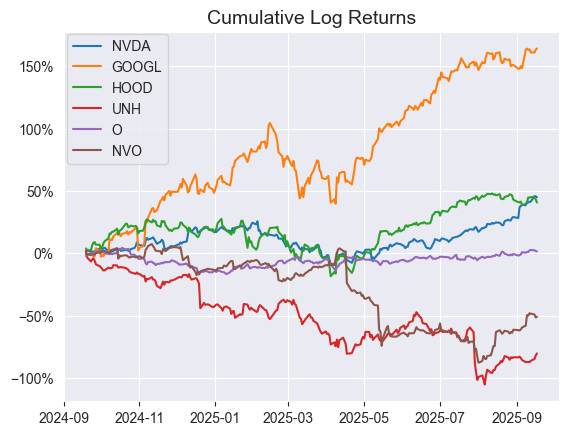

In [3]:
import matplotlib.pyplot as plt
from matplotlib import ticker
from logReturns import logReturns

tickers = "NVDA GOOGL HOOD UNH O NVO"
period = "1y" #one of: [1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max]

logs = logReturns(tickers, period).cumsum()
#standard = np.exp(logs)-1
fig, ax = plt.subplots()
ax.plot(logs)
ax.set_title("Cumulative Log Returns",fontdict = {"fontsize":14})
fig.legend(labels = tickers.split(" "), loc = "upper left", bbox_to_anchor = (0.12,0.89))
ax.xaxis.tick_bottom()
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax = 1))

## Portfolio Variance and Sharpe Ratios
Calculating portfolio returns simply involves taking the dot product between asset weights and returns. However, due to their being correlation and covariance between assets within a portfolio, calculating the portfolios variance (or standard deviation) is not as simple.<br>
Portfolio variance is defined as follows, where $w_{i}$ is the weight of each asset, $Cov(a_{i},a_{j})$ is the covariance between assets $a_{i},a_{j}$, and n is the number of assets
### $\sigma_{P}^{2} = \sum_{i=1}^{n} \sum_{j=1}^{n} w_{i}w_{j} Cov(a_{1},a_{2})$
This is equivalent to
### $\sigma_{P}^{2} = W^{T}C_{v}W$
Where W is a column vector of asset weights and $C_{v}$ is the covariance matrix.<br>
*Note: Depending on the period of returns being analysed, the covariance matrix must be scaled to fit that period. E.g. if the covariance matrix was derived from daily log returns, but annualised portfolio variance is the desired output then the covariance matrix must be multiplied by the number of trading days in a year (252).*<br><br>
A Sharpe ratio describes how much excess return a portfolio (or asset) produces per unit of risk. It is defined as follows, where $R_{P}$ is the portfolios (or assets) return, $R_{f}$ is the risk-free return, and $\sigma_{P}$ is the portfolio (or assets) standard deviation
### Sharpe $= \frac{R_{P}-R_{f}}{\sigma_{P}}$
*Note: $R_{P}$ and $R_{f}$ must be in standard terms and not logarithmic for the purpose of calculating Sharpe.*<br>
*Also note: All three inputs must cover the same time period. It is unfair, for example, to use the portfolios 12 month return but only its standard deviation over 6 months.*
<br><br>
In the following example we consider a portfolio consisting of the same assets, however with randomly generated weights. From this we compute the portfolios return, standard deviation (volatility), and Sharpe ratio for the past 12 month period.

In [4]:
import numpy as np
import yfinance as yf
from pandas import DataFrame
from logReturns import logReturns
from vol import vol
rng = np.random.default_rng()

port_value = 10000 #USD
rf = 0.04 #risk-free rate
tickers = "NVDA GOOGL HOOD UNH O NVO"

randoms = rng.integers(low = 1000, high = 5000, size = len(tickers.split(" ")))
values = port_value*randoms/sum(randoms)
close = yf.Tickers(tickers).history(period = "1d", progress = False)["Close"].iloc[-1,:]
port = DataFrame(index = tickers.split(" ")) #random weighted portfolio of symbols in tickers
logs = logReturns(tickers,"1y")
port["Position"] = np.floor_divide(values,close,dtype = "int64", casting = "unsafe")
port["Log Return"] = logs.sum().round(3)
port["Volatility"] = vol(tickers,"1y")[1].round(3)
port["Weight"] = ((port["Position"]*close)/sum(port["Position"]*close)).round(3)
port.index.name = "Holding"
port_log = (port["Log Return"]*port["Weight"]).sum()
port_real = np.exp(port_log)-1
port_variance = np.dot(port["Weight"].T,np.dot(logs.cov()*252,port["Weight"]))
print(f"{port}\n--\nLog return: {"{:.2%}".format(port_log)}\n"
      f"Volatility: {"{:.2%}".format(np.sqrt(port_variance))}\n"
      f"Sharpe: {((port_real-rf)/np.sqrt(port_variance)).round(3)}")

         Position  Log Return  Volatility  Weight
Holding                                          
NVDA           11       0.407       0.500   0.197
GOOGL           7       0.450       0.321   0.184
HOOD           11       1.643       0.756   0.138
UNH             3      -0.509       0.511   0.108
O              30       0.015       0.186   0.189
NVO            30      -0.803       0.518   0.184
--
Log return: 18.98%
Volatility: 26.90%
Sharpe: 0.628


## The Risk-Return Scatter Plot

The following example expands on the above simulation by simultaneously generating 1000 (or some other number) randomly weighted portfolios and computing their returns, variance, and Sharpe ratios over the past 12 month period. This allows us to generate a risk-return scatter plot where each randomly generated portfolio is a single point.<br><br>
From this we can see that on average more risk (higher volatility) does indeed equal more reward (greater return) as supported by the risk-return scatter having a correlation coefficient of 0.644. However, what is slightly more surprising is how higher risk (volatility) also tends to lead to a higher Sharpe (indicated by the lighter colour). Suggesting that, in this case, the positive effect on the Sharpe ratio of increased returns from taking on more risk outweighs the negative effect of the increased risk itself.

             Value  GOOGL  HOOD  NVDA  NVO   O  UNH  Return  Volatility  Sharpe
Portfolio                                                                      
0          9395.03      5     7     9   40  35    4   0.002       0.245  -0.155
1          9591.27      6    11    11   33  33    3   0.161       0.261   0.516
2          9641.56      8    11     9   21  20    7   0.154       0.270   0.468
3          9235.29      4    14     6   23  42    5   0.183       0.253   0.636
4          9264.92      7    10     8   26  35    4   0.152       0.244   0.509
--
Mean log return: 20.42%
Mean volatility: 27.96%
Mean Sharpe: 0.676
Risk-Return correlation coefficient: 0.644


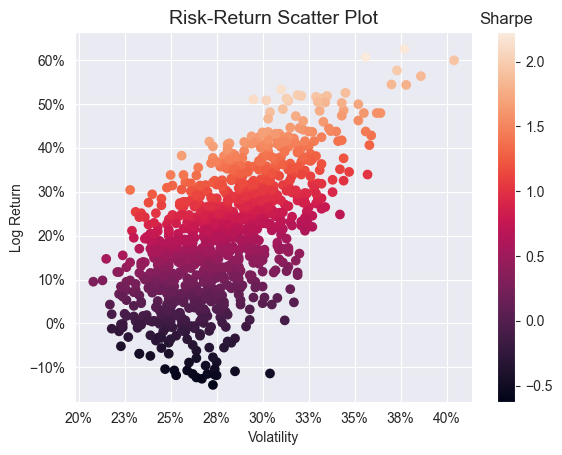

In [5]:
import numpy as np
import pandas as pd
import yfinance as yf
from logReturns import logReturns
from pandas import DataFrame
import matplotlib.pyplot as plt
from matplotlib import ticker
rng = np.random.default_rng()

port_value = 10000 #USD
no_ports = 1000
rf = 0.04 #risk-free rate
tickers = "NVDA GOOGL HOOD UNH O NVO"

randoms = rng.integers(low = 1000, high = 5000, size = (no_ports,len(tickers.split(" "))))
values = port_value*(randoms/randoms.sum(axis = 1).reshape(no_ports,1))
close = np.array(yf.Tickers(tickers).history(period = "1d", progress = False)["Close"].iloc[-1,:])
position = DataFrame(np.floor_divide(values,close,dtype = "int64",casting = "unsafe"), columns = sorted(tickers.split(" ")))
logs = logReturns(tickers, "1y")
log_return = np.array(logs.sum()).reshape(1,np.shape(logs.sum())[0])
weight = (position*close)/np.array((position*close).sum(axis = 1)).reshape(no_ports,1)
port_returns = weight.dot(log_return.T)
ports = DataFrame({"Value":(position*close).sum(axis = 1).round(2)}).join(position)
ports["Return"] = port_returns.round(3)
ports["Volatility"] = np.sqrt(np.diag(np.dot(weight,np.dot(logs.cov()*252,weight.T)))).round(3)
ports["Sharpe"] = ((np.exp(ports["Return"]) - 1 - rf)/ports["Volatility"]).round(3)
ports.index.name = "Portfolio"
pd.set_option('display.expand_frame_repr', False)
print(ports.head())

fig, ax = plt.subplots()
plot = ax.scatter(ports["Volatility"], ports["Return"], c = ports["Sharpe"])
ax.set_title("Risk-Return Scatter Plot", fontdict = {"fontsize":14})
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax = 1, decimals = 0)), ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax = 1, decimals = 0))
ax.set_xlabel("Volatility"), ax.set_ylabel("Log Return")
clb = fig.colorbar(plot)
clb.ax.set_title("Sharpe")

print(f"--\n"
      f"Mean log return: {"{:.2%}".format(ports["Return"].mean())}\n"
      f"Mean volatility: {"{:.2%}".format(ports["Volatility"].mean())}\n"
      f"Mean Sharpe: {ports["Sharpe"].mean().round(3)}\n"
      f"Risk-Return correlation coefficient: {(DataFrame({"Return":ports["Return"],"Volatility":ports["Volatility"]}).corr().loc["Return","Volatility"]).round(3)}")